In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch

plt.rcParams['figure.facecolor'] = 'white'

In [11]:
distmat = np.load("distmat.npy")
gf = np.load("gf.npy")
qf = np.load("qf.npy")
with open("other.json") as f:
    other = json.load(f)
other.keys()

dict_keys(['q_pids', 'g_pids', 'q_camids', 'g_camids'])

In [12]:
q_pids = other["q_pids"]
g_pids = other["g_pids"]

In [13]:
distmat.shape

(2228, 17661)

In [14]:
gf.shape

(17661, 2048)

In [15]:
qf.shape

(2228, 2048)

In [16]:
g_pids = other["g_pids"]
q_pids = other["q_pids"]

In [17]:
g_pids = np.array(g_pids)
q_pids = np.array(q_pids)

## Distance Distributions

In [18]:
def compute_matches(distance, q_pids, g_pids):
    g = g_pids.shape[0]
    q_pids = q_pids.reshape(-1, 1)
    q = q_pids.shape[0]
    distance = distance.reshape(-1, g)
    assert(distance.shape[0] == q_pids.shape[0])
    ranked_indices = distance.argsort(axis=1)
    ranked_pids = g_pids[ranked_indices]
    ranked_matches = ranked_pids == q_pids.repeat(g, axis=1)  # np repeat
    return ranked_matches, ranked_indices

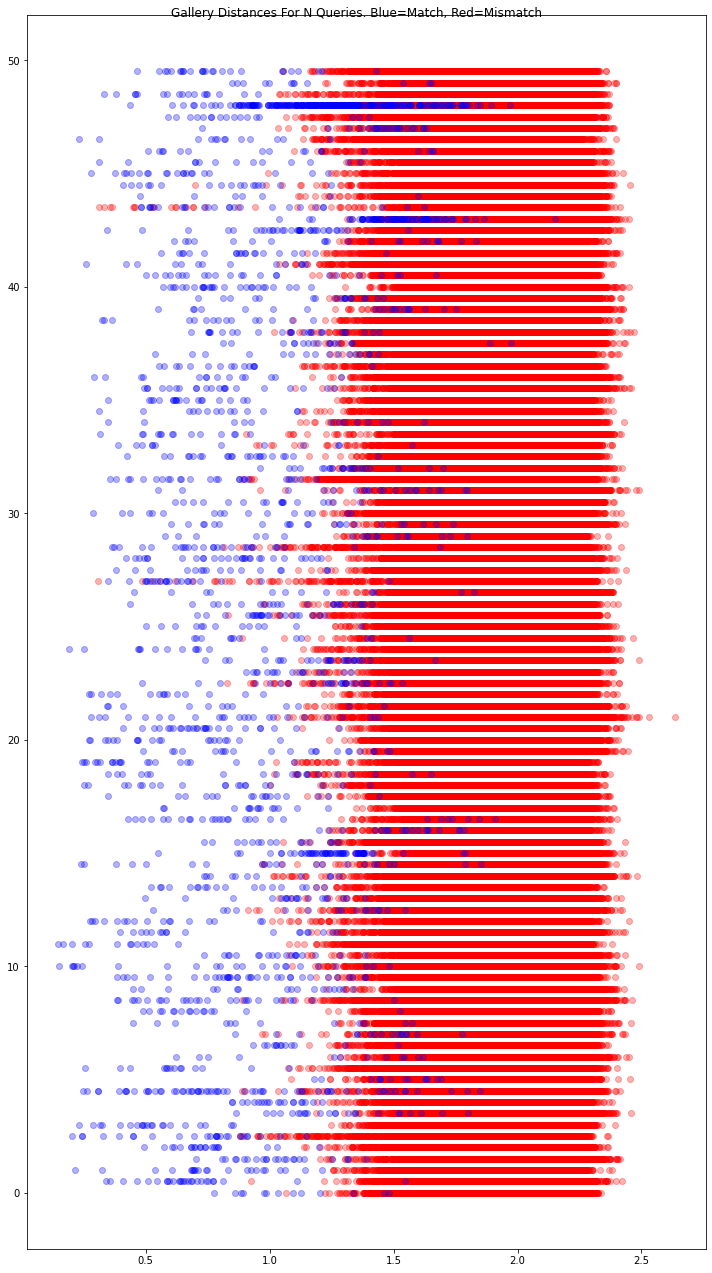

In [23]:
plt.figure(figsize=(10, 18))
plt.suptitle("Gallery Distances For N Queries. Blue=Match, Red=Mismatch")
for i in range(100):
    ranked_matches, ranked_indices = compute_matches(distmat[i], q_pids[i], g_pids)
    mismatching = ranked_indices[ranked_matches == False]
    matching = ranked_indices[ranked_matches]
    plt.scatter(distmat[i][mismatching], np.ones(mismatching.shape) * i / 2, color="red", alpha=0.3)
    plt.scatter(distmat[i][matching], np.ones(matching.shape) * i / 2, color="blue", alpha=0.3)
plt.tight_layout()

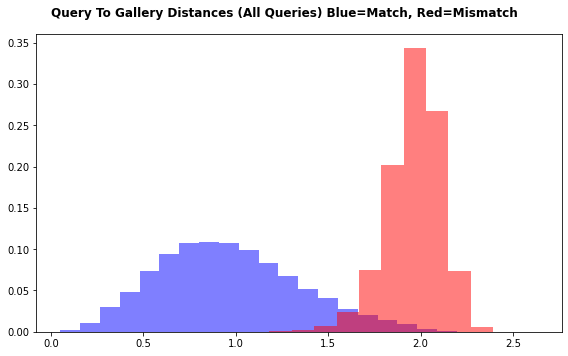

In [351]:
figure = plt.figure(figsize=(8, 5))
plt.suptitle("Query To Gallery Distances (All Queries) Blue=Match, Red=Mismatch", fontweight="bold")
ranked_matches, ranked_indices = compute_matches(distmat, q_pids, g_pids)

counts, bins = np.histogram(np.sort(distmat, axis=1)[ranked_matches], bins=20)
plt.hist(bins[:-1], bins, weights=counts / ranked_matches.astype(int).sum(), color="blue", alpha=0.5)
counts, bins = np.histogram(np.sort(distmat, axis=1)[ranked_matches == False], bins=20)
plt.hist(bins[:-1], bins, weights=counts / (ranked_matches == False).astype(int).sum(), color="red", alpha=0.5)
plt.tight_layout()
figure.savefig("Query Gallery Distances.png", dpi=320)

In [352]:
from post_rank.hvil import HVIL
hvil = HVIL(qf, gf)

## Cumulate Inter-Gallery Distances

In [353]:
gdvs = []
match_distances = []
mismatch_distances = []

In [354]:
for i, g_pid in tqdm(list(enumerate(g_pids))[len(gdvs):]):
    g = g_pids.shape[0]
    gdv = hvil._compute_gallery_distance_vector(i)
    ranked_matches, ranked_indices = compute_matches(gdv, g_pid, g_pids)
    mismatching = ranked_indices[ranked_matches == False]
    matching = ranked_indices[ranked_matches]
    
    match_distance = gdv[matching.flatten()]
    mismatch_distance = gdv[mismatching.flatten()]
    
    gdvs.append(gdv)
    match_distances.append(match_distance)
    mismatch_distances.append(mismatch_distance)

  7%|▋         | 1271/17661 [16:29<3:32:41,  1.28it/s]


KeyboardInterrupt: 

In [311]:
if input("Save gdvs?") == "y":
    c_gdvs = gdvs
    c_match_distances = match_distances
    c_mismatch_distances = mismatch_distances

Save gdvs?y


In [165]:
if input("Load gdvs?") == "y":
    gdvs = c_gdvs
    match_distances = c_match_distances
    mismatch_distances = c_mismatch_distances

In [355]:
ranked = np.stack(gdvs).argsort(axis=1)
ranked_pids = g_pids[ranked]
print("ranked_pids", ranked_pids.shape)
true_pids = g_pids[np.arange(0, len(gdvs))]
print("true_pids", true_pids.shape)
print("true_pids_repeated", true_pids.reshape(-1, 1).shape)
match_by_rank = (ranked_pids == true_pids.reshape(-1, 1).repeat(g_pids.shape[0], axis=1))
print("match_by_rank", match_by_rank.shape)
match_ratio_by_rank = match_by_rank.astype(int).mean(axis=0)

ranked_pids (1271, 17661)
true_pids (1271,)
true_pids_repeated (1271, 1)
match_by_rank (1271, 17661)


In [356]:
match_by_rank[:20,:20].astype(int)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

In [357]:
match_ratio_by_rank[:50]

array([1.        , 0.96538159, 0.96144768, 0.94413847, 0.9166011 ,
       0.87018096, 0.83005507, 0.79858379, 0.76868607, 0.75295043,
       0.72619984, 0.68607396, 0.64988198, 0.62155783, 0.58536585,
       0.54130606, 0.51219512, 0.47836349, 0.45318647, 0.42407553,
       0.39732494, 0.37844217, 0.35798584, 0.33910307, 0.29740362,
       0.29504327, 0.27301338, 0.25570417, 0.26199843, 0.24626279,
       0.23052714, 0.23446105, 0.23446105, 0.21872541, 0.21321794,
       0.21085759, 0.21085759, 0.20535012, 0.18725413, 0.18489378,
       0.18882769, 0.1974823 , 0.17859953, 0.18332022, 0.16837136,
       0.16522423, 0.17151849, 0.16915814, 0.15499607, 0.14791503])

1271 1271


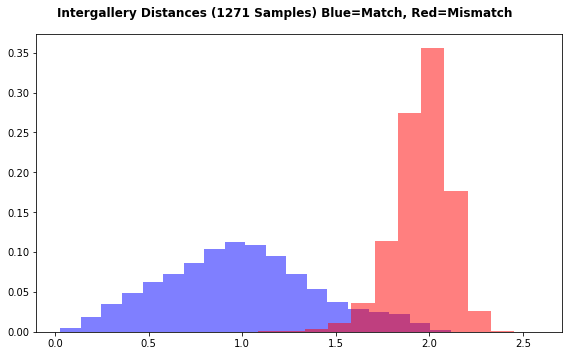

In [358]:
match_d = np.concatenate(match_distances)
print((match_d == 0).astype(int).sum(), len(match_distances))  # assert no images w/ equal embedding
match_d = match_d[match_d != 0]
mismatch_d = np.concatenate(mismatch_distances)

figure = plt.figure(figsize=(8, 5))
plt.suptitle("Intergallery Distances ({} Samples) Blue=Match, Red=Mismatch".format(
    len(gdvs), len(set(g_pids.tolist()))), fontweight="bold")
cut = 20
counts, bins = np.histogram(match_d, bins=20)
plt.hist(bins[:cut], bins[:cut + 1], weights=counts[:cut] / counts[:cut].sum(), color="blue", alpha=0.5)
counts, bins = np.histogram(mismatch_d, bins=20)
plt.hist(bins[:cut], bins[:cut + 1], weights=counts[:cut] / counts[:cut].sum(), color="red", alpha=0.5)
plt.tight_layout()
figure.savefig("Intergallery Distances.png", dpi=320)

[0.         0.43775088 0.56690294 0.57589966 0.5760064  0.679329
 0.72448546 0.7550751  0.76504755 0.76924187 0.80687827 0.9035661
 0.9612708  0.98775303 1.0425032  1.0870917  1.1265095  1.1996801
 1.2051206  1.2120833 ]
[1.1454611 1.1504288 1.1567513 ... 2.3920424 2.40386   2.4372134]


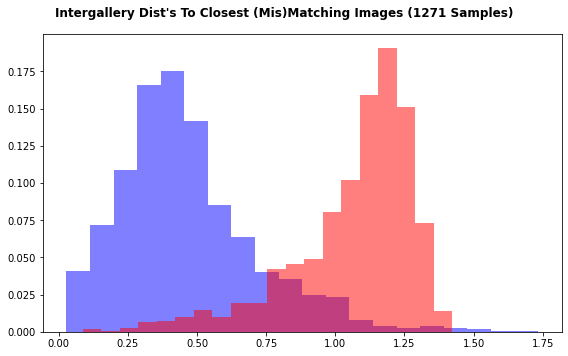

In [359]:
initial_match_d = []
initial_mismatch_d = []
for mdv in match_distances:
    mdv_sorted = np.sort(mdv)
    assert(mdv_sorted[0] == 0)  # self
    initial_match_d.append(mdv_sorted[1])  # next closest
for mdv in mismatch_distances:
    initial_mismatch_d.append(mdv.min())
    
print(np.sort(match_distances[1]))
print(np.sort(mismatch_distances[1]))

figure = plt.figure(figsize=(8, 5))
plt.suptitle("Intergallery Dist's To Closest (Mis)Matching Images ({} Samples)".format(
    len(gdvs)), fontweight="bold")
counts, bins = np.histogram(initial_match_d, bins=20)
plt.hist(bins[:-1], bins, weights=counts / counts.sum(), color="blue", alpha=0.5)
counts, bins = np.histogram(initial_mismatch_d, bins=20)
plt.hist(bins[:-1], bins, weights=counts / counts.sum(), color="red", alpha=0.5)
plt.tight_layout()
figure.savefig("Intergallery Distances Clostest.png", dpi=320)

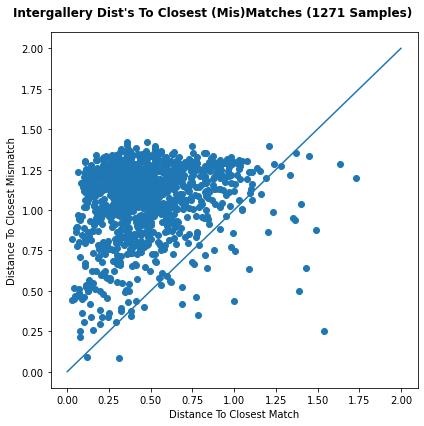

In [360]:
figure = plt.figure(figsize=(6, 6))
np.set_printoptions(threshold=8000)
pairs = np.array([initial_match_d, initial_mismatch_d]).T
plt.scatter(initial_match_d, initial_mismatch_d)
plt.plot([0, 2], [0, 2])
plt.xlabel("Distance To Closest Match")
plt.ylabel("Distance To Closest Mismatch")
plt.suptitle("Intergallery Dist's To Closest (Mis)Matches ({} Samples)".format(
    len(gdvs)), fontweight="bold")
plt.tight_layout()

figure.savefig("Intergallery Distances Comparison.png", dpi=320)

In [361]:
near_match = np.array(initial_match_d) < np.array(initial_mismatch_d)
near_match.sum(), len(initial_match_d)

(1227, 1271)

In [61]:
from post_rank.hvil import HVIL
hvil = HVIL(qf, gf)

In [62]:
hvil_dvs = []
for i in range(20):
    print("#" * 80)
    q_pid = q_pids[i]
    
    hvil = HVIL(qf, gf)
    ranked = hvil.compute_distance_vector(i).argsort()
    g_pid_ranked = torch.Tensor(g_pids)[ranked]
    matches = (g_pid_ranked == q_pid).int()
    decreasing = (1 - matches) * torch.Tensor(np.arange(matches.shape[-1] + 1, 1, -1))
    error_rank = decreasing.argmax()
    error_position = ranked[error_rank]
    print(matches[:20])
    
    for t in range(10):
        for j in ranked[1:]:
            if g_pids[j] == q_pid:
                hvil.feedback(q_index=i, g_index=j, match=g_pids[j] == q_pid)
                dv = hvil.compute_distance_vector(i)
                ranked = dv.argsort()
                g_pid_ranked = torch.Tensor(g_pids)[ranked]
                matches = (g_pid_ranked == q_pid).int()
                print()
                print(matches[:20])
                break
    
    
    hvil_dvs.append(dv)

################################################################################
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([157]),)
l_hat tensor(5.6366)
_part tensor(8.5106)
f_hat tensor(0.9989)
f_t tensor(3.1361)
0.9989127516746521
0.9989127516746521

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([1346]),)
l_hat tensor(7.7825)
_part tensor(32.0331)
f_hat tensor(1.8982)
f_t tensor(4.3953)
1.8981873989105225
1.898187518119812

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([15562]),)
l_hat tensor(10.2298)
_part tensor(152.4165)
f_hat tensor(4.3953)
f_t tensor(6.8083)
4.395329475402832
4.395328521728516

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([17419]),)
l_hat tensor(10.3426)
_part tensor(330.7053)
f_hat tensor(6.8083)
f_t tensor(9.413


tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([1]),)
l_hat tensor(1.)
_part tensor(0.8829)
f_hat tensor(0.7486)
f_t tensor(3.0209)
0.748591423034668
0.7485912442207336

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([382]),)
l_hat tensor(6.5239)
_part tensor(80.0687)
f_hat tensor(2.7516)
f_t tensor(8.9550)
2.751573085784912
2.751573085784912

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([266]),)
l_hat tensor(6.1626)
_part tensor(389.6596)
f_hat tensor(5.6986)
f_t tensor(22.2060)
5.698590278625488
5.698588848114014

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([1061]),)
l_hat tensor(7.5447)
_part tensor(6084.8228)
f_hat tensor(22.2055)
f_t tensor(72.6439)
22.20554542541504
22.20553970336914

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

rank (tensor([1]),)
l_hat tensor(1.)
_part tensor(0.9269)
f_hat tensor(0.8739)
f_t tensor(2.8283)
0.873950183391571
0.8739499449729919

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([65]),)
l_hat tensor(4.7593)
_part tensor(29.2685)
f_hat tensor(1.6231)
f_t tensor(7.6329)
1.6230993270874023
1.6230998039245605

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([1035]),)
l_hat tensor(7.5199)
_part tensor(354.1147)
f_hat tensor(4.7383)
f_t tensor(19.8900)
4.738285064697266
4.738284587860107

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([2702]),)
l_hat tensor(8.4791)
_part tensor(5702.0024)
f_hat tensor(18.5994)
f_t tensor(72.3144)
18.599430084228516
18.599435806274414

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([3463]),)
l_hat tensor(8.7273)
_pa

rank (tensor([20]),)
l_hat tensor(3.5977)
_part tensor(1817.5875)
f_hat tensor(14.0401)
f_t tensor(71.9732)
14.040133476257324
14.040129661560059

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([1]),)
l_hat tensor(1.)
_part tensor(7418.7432)
f_hat tensor(42.9855)
f_t tensor(345.1797)
42.98555374145508
42.985530853271484

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([1]),)
l_hat tensor(1.)
_part tensor(474830.5312)
f_hat tensor(345.6442)
f_t tensor(2747.5117)
345.644287109375
345.6441650390625

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([1]),)
l_hat tensor(1.)
_part tensor(19451920.)
f_hat tensor(2213.6538)
f_t tensor(17574.4922)
2213.654296875
2213.65380859375

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
##############################################

rank (tensor([4893]),)
l_hat tensor(9.0729)
_part tensor(6390179.)
f_hat tensor(769.0524)
f_t tensor(1831.6481)
769.05224609375
769.0523681640625

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([4945]),)
l_hat tensor(9.0834)
_part tensor(2.9042e+08)
f_hat tensor(5187.4614)
f_t tensor(12326.7246)
5187.4609375
5187.46142578125

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
################################################################################
tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([4]),)
l_hat tensor(2.0833)
_part tensor(1.5555)
f_hat tensor(0.7379)
f_t tensor(2.4203)
0.7379000186920166
0.7378998398780823

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([30]),)
l_hat tensor(3.9950)
_part tensor(8.6434)
f_hat tensor(1.1727)
f_t tensor(3.8208)
1

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([51]),)
l_hat tensor(4.5188)
_part tensor(4.1936)
f_hat tensor(0.6963)
f_t tensor(2.8225)
0.6962844133377075
0.6962843537330627

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([336]),)
l_hat tensor(6.3958)
_part tensor(17.1626)
f_hat tensor(1.2783)
f_t tensor(4.2715)
1.2783396244049072
1.2783399820327759

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([4752]),)
l_hat tensor(9.0436)
_part tensor(127.2070)
f_hat tensor(3.5028)
f_t tensor(8.0586)
3.502833843231201
3.502833366394043

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([7862]),)
l_hat tensor(9.5471)
_part tensor(486.6488)
f_hat tensor(6.9229)
f_t tensor(14.7404)
6.922858238220215
6.922857761383057

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0


tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([1]),)
l_hat tensor(1.)
_part tensor(-0.3760)
f_hat tensor(0.3662)
f_t tensor(0.7209)
0.36622437834739685
0.36622437834739685

tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       dtype=torch.int32)
rank (tensor([1]),)
l_hat tensor(1.)
_part tensor(0.0452)
f_hat tensor(0.5720)
f_t tensor(1.4955)
0.571968674659729
0.571968674659729

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([53]),)
l_hat tensor(4.5569)
_part tensor(11.7549)
f_hat tensor(1.1920)
f_t tensor(4.4274)
1.191967248916626
1.1919670104980469

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
rank (tensor([992]),)
l_hat tensor(7.4774)
_part tensor(83.7810)
f_hat tensor(2.3239)
f_t tensor(9.6703)
2.323948860168457
2.3239493370056152

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

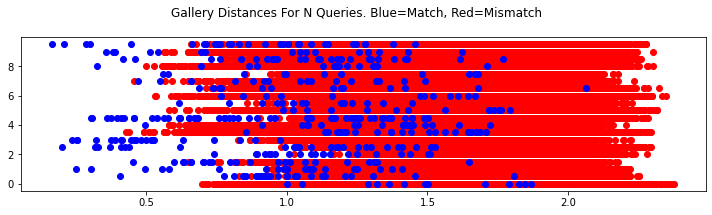

In [63]:
plt.figure(figsize=(10, 3))
plt.suptitle("Gallery Distances For N Queries. Blue=Match, Red=Mismatch")
for i in range(20):
    ranked, matching, mismatching = compute_matches(distmat[i], q_pids[i], g_pids)
    plt.scatter(distmat[i][mismatching], np.ones(mismatching.shape) * i / 2, color="red")
    plt.scatter(distmat[i][matching], np.ones(matching.shape) * i / 2, color="blue")
plt.tight_layout()

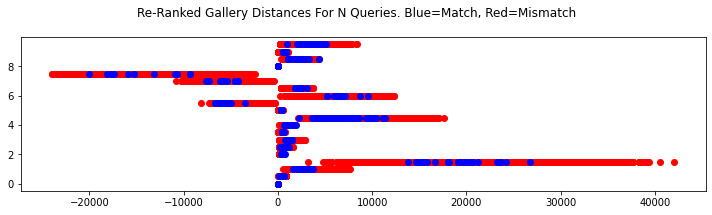

In [66]:
plt.figure(figsize=(10, 3))
plt.suptitle("Re-Ranked Gallery Distances For N Queries. Blue=Match, Red=Mismatch")
for i in range(20):
    ranked, matching, mismatching = compute_matches(hvil_dvs[i], q_pids[i], g_pids)
    plt.scatter(hvil_dvs[i][mismatching], np.ones(mismatching.shape) * i / 2, color="red")
    plt.scatter(hvil_dvs[i][matching], np.ones(matching.shape) * i / 2, color="blue")
plt.tight_layout()

In [ ]:
ranks = distmat.argsort(axis=1)
g_pid_ranked = torch.Tensor(g_pids)[ranks]
q_pid_tensor = torch.Tensor(q_pids).reshape(-1, 1)
matches = (g_pid_ranked == q_pid_tensor).int()
match_counts = matches.sum(axis=1)
increasing = matches * torch.Tensor(np.arange(1, 17662))
final_ranks = matches.argmax(axis=1).int()

In [32]:
final_ranks

tensor([142, 217,  21,  ...,  68, 184,  32], dtype=torch.int32)

In [33]:
final_ranks.argmax()

tensor(927)

In [34]:
final_ranks[927]

tensor(17245, dtype=torch.int32)

In [11]:
matches[:20,:24]

tensor([[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1

In [12]:
inp = match_counts.true_divide(final_ranks)
minp = inp.mean()

In [13]:
minp.cpu().numpy().item()

0.41596680879592896

In [14]:
(final_ranks - match_counts).double().mean().cpu().numpy().item()

422.3

<AxesSubplot:title={'center':'Number of negative images until final match'}, xlabel='0'>

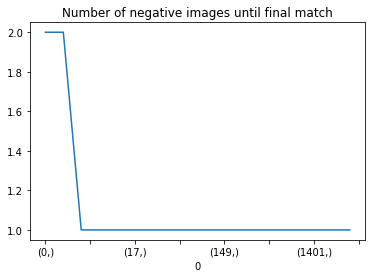

In [15]:
pd.DataFrame(final_ranks - match_counts + 1).value_counts().plot(title="Number of negative images until final match")

In [ ]:
hvil_dm = torch.Tensor(np.stack(hvil_dvs))

In [26]:
ranks = hvil_dm.argsort(axis=1)
g_pid_ranked = torch.Tensor(g_pids)[ranks]
q_pid_tensor = torch.Tensor(q_pids).reshape(-1, 1)[:ranks.shape[0]]
matches = (g_pid_ranked == q_pid_tensor).int()
match_counts = matches.sum(axis=1)[:ranks.shape[0]]
increasing = matches * torch.Tensor(np.arange(1, 17662))
final_ranks = matches.argmax(axis=1)
final_ranks

NameError: name 'hvil_dm' is not defined

In [ ]:
inp = match_counts.true_divide(final_ranks)
minp = inp.mean()

In [97]:
minp.cpu().numpy().item()

0.40952426195144653

In [98]:
(final_ranks - match_counts).double().mean().cpu().numpy().item()

474.95